In [15]:
using Pkg
Pkg.activate("../alp")
using YAML
include("Env.jl")
include("BaseTypes.jl")
include("DQN.jl")

  Activating project at `~/Desktop/RLFinance/alp`
  Activating project at `~/Desktop/RLFinance/alp`
  Activating project at `~/Desktop/RLFinance/alp`


  Activating project at `~/Desktop/RLFinance/alp`
  Activating project at `~/Desktop/RLFinance/alp`


   Resolving package versions...


  No Changes to `~/Desktop/RLFinance/alp/Project.toml`
  No Changes to `~/Desktop/RLFinance/alp/Manifest.toml`


  Activating project at `~/Desktop/RLFinance/alp`
  Activating project at `~/Desktop/RLFinance/alp`
  Activating project at `~/Desktop/RLFinance/alp`


order_action (generic function with 1 method)

In [35]:
CONFIG = "../config/test.yml"
c = YAML.load_file(CONFIG)

PATH = c["path_df"]
PATH_ = "../data/roman_raw.csv"
df = CSV.read(PATH, DataFrame)

train_env = Env(
    df[c["train_start_idx"] : c["train_end_idx"], :]; 
    w_size       = c["window_step"], 
    commission   = c["commission"], 
    exclude_cols = c["exclude_cols"]
)
test_env = Env(
    df[c["test_start_idx"] : end, :]; 
    w_size       = c["window_step"], 
    commission   = c["commission"], 
    exclude_cols = c["exclude_cols"]
)

# step_ = T(1.0)
# max_ = T(5.0)
# actions = [Iterators.product(step_:step_:max_, step_:step_:max_)...]
# pushfirst!(actions, (0.0, 0.0))

actions = T.(c["actions"])

actions = [Iterators.product(actions, actions)...]
pushfirst!(actions, (0.0, 0.0))
display(actions)

dqn = init!(
    in_feats  = length(train_env.real_feats),
    layers    = c["layers"],
    eps_start = c["eps_start"],
    eps_end   = c["eps_end"],
    eps_decay = c["eps_decay"],
    rew_decay = c["reward_decay"],
    lr        = c["lr"],
    reg_vol   = c["reg_vol"],
    # lr_end    = 1e-?
    # lr_decay  = 
    action_space = actions
)


2-element Vector{Tuple{Float32, Float32}}:
 (0.0, 0.0)
 (0.1, 0.1)

KeyError: KeyError: key "layers" not found

In [36]:
# old_state = deepcopy(dqn.target_model[])
train_dqn(
    dqn,
    train_env;
    episodes=10000,
    max_ep_len=10,
    step_=window_step,
    replay_memory_len=512,
    replay_batch=32
)

# new_state = deepcopy(dqn.target_model[])

In [ ]:
using Plots
s = 9900
plot(dqn.stats["reward"][s:end])
plot!(twinx(), dqn.stats["vol_left"][s:end], color=:red)
# savefig("../train.png") 
# plot(train_env.data.PnL)

In [ ]:
move(dqn, true, false)
res = simulate!(test_env; 
    order_action = order_action, 
    step_  = window_step, 
    kwargs = dqn,
    clear_env_at_step = true
)
plot(res["reward"])
# savefig("../test.png") 
# plot(test_env.data[:,"midprice"])

In [ ]:
T_ = 100
SIGMA_NAME = "vol_ws2500_midprice_vwap_v130000.0"
function baseline(env, state, kwargs)
    delta = state[SIGMA_NAME] / 10000 * sqrt(T_)
    input_order(env, Order(true, 1.0, state["midprice"] + delta))
    input_order(env, Order(false, 1.0, state["midprice"] - delta))
end

res_base = simulate!(train_env, baseline, trading_step-1, nothing)

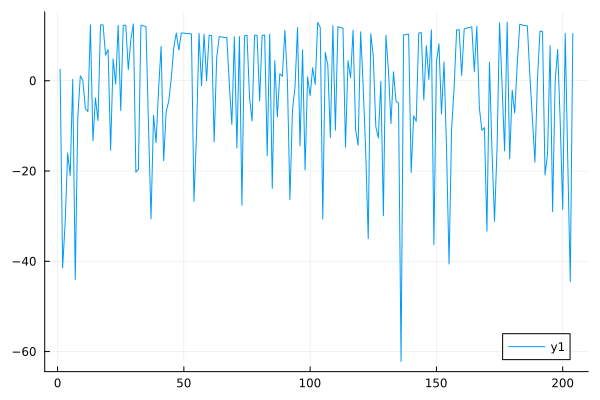

In [52]:
plot(res_base["reward"])

In [29]:
include("BaseTypes.jl")

orders = [
    Order(true, 1.0, 130),
    Order(false, 1.0, 110)
]

res = match_orders!(
    orders=orders, best_ask = 131.0, best_bid = 109.0
)


  Activating project at `~/Desktop/RLFinance/alp`


MatchRes(0.0, 20.0, 2)

In [14]:
dqn.target_model[](cu([get_state(train_env)...]))

5-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 -0.24641226
 -0.26526147
 -0.26094928
 -0.3081943
 -0.2775164